In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import utils


In [12]:
import data_loading
df = data_loading.hilbert_dataframe_from_folder("data", crop_size=256)

labels = df.columns

print(df.columns)


Index(['img_0001.jpg', 'img_0002.jpg', 'img_0008.jpg', 'img_0023.jpg',
       'img_0057.jpg', 'img_0060.jpg', 'img_0064.jpg', 'img_0103.jpg'],
      dtype='object')


# Ordinal patterns para m = 3, 4, 5 y tau = 1, 2

In [ ]:
# Parámetros de embedding

m_values = [3, 4, 5]
tau_values = [1, 2]

for m, tau in product(m_values, tau_values):
    
    cols = df.columns
    ncols = 3
    nrows = int(np.ceil(len(cols) / ncols))
    
    plt.figure(figsize=(15, 4 * nrows))
    plt.title(f'm={m}, tau={tau}\n')
    for i, col in enumerate(cols, 1):
        x = df[col].values
    
        try:
            _, counts = utils.ordinal_patterns(x, emb_dim=m, emb_lag=tau)
            prob = counts / counts.sum()
        except ValueError:
            continue
    
        plt.subplot(nrows, ncols, i)
        plt.bar(np.arange(len(prob)), prob)
        plt.title(f"{col}")
        plt.xlabel("Índice de patrón")
        plt.ylabel("Probabilidad")
        plt.ylim(0, prob.max() * 1.2)
    
    plt.tight_layout()
    plt.show()


# Calculo entropias normalizadas

In [8]:
import divergence_entropy
import importlib
importlib.reload(divergence_entropy)
import pandas as pd

def entropy_complexity_full(dfs, m_values, tau_values, alpha=2.0, q=2.0):
    
    rows = []
    
    for col in df.columns:
        x = df[col].values

        for m, tau in product(m_values, tau_values):
            _, counts = utils.ordinal_patterns(x, emb_dim=m, emb_lag=tau)
            prob = counts / counts.sum()

            rows.append({
                "image": col,
                "m": m,
                "tau": tau,

                "H_shannon": divergence_entropy.shannon_entropy_normalized(prob),
                "C_shannon": divergence_entropy.complexity_shannon(prob),

                "H_renyi": divergence_entropy.renyi_entropy_normalized(prob, alpha),
                "C_renyi": divergence_entropy.complexity_renyi(prob, alpha),

                "H_tsallis": divergence_entropy.tsallis_entropy_normalized(prob, q),
                "C_tsallis": divergence_entropy.complexity_tsallis(prob, q),
            })
    
            
    return pd.DataFrame(rows)


In [9]:
entropy_complexity_df = entropy_complexity_full(df, m_values, tau_values)

In [10]:

ENTROPY_SPECS = {
    "shannon": {
        "H_col": "H_shannon",
        "C_col": "C_shannon",
        "H_func": divergence_entropy.shannon_entropy_normalized,
        "D_func": divergence_entropy.jensen_shannon_divergence_normalized,
        "label": "Shannon",
    },
    "renyi": {
        "H_col": "H_renyi",
        "C_col": "C_renyi",
        "H_func": lambda p: divergence_entropy.renyi_entropy_normalized(p, alpha=2.0),
        "D_func": lambda p: divergence_entropy.jensen_renyi_divergence_normalized(p, alpha=2.0),
        "label": r"Rényi ($\alpha=2$)",
    },
    "tsallis": {
        "H_col": "H_tsallis",
        "C_col": "C_tsallis",
        "H_func": lambda p: divergence_entropy.tsallis_entropy_normalized(p, q=2.0),
        "D_func": lambda p: divergence_entropy.jensen_tsallis_divergence_normalized(p, q=2.0),
        "label": r"Tsallis ($q=2$)",
    },
}


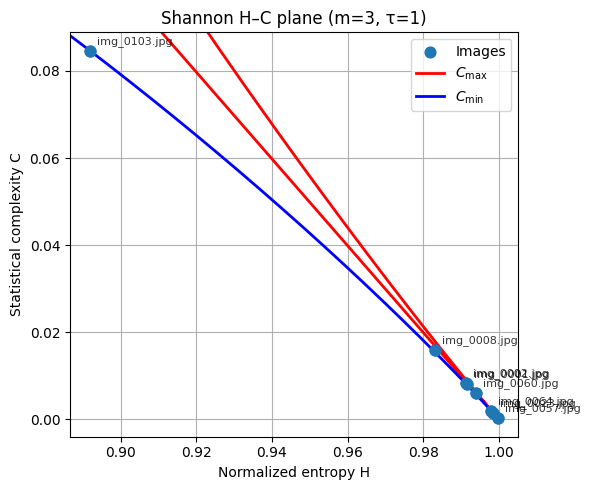

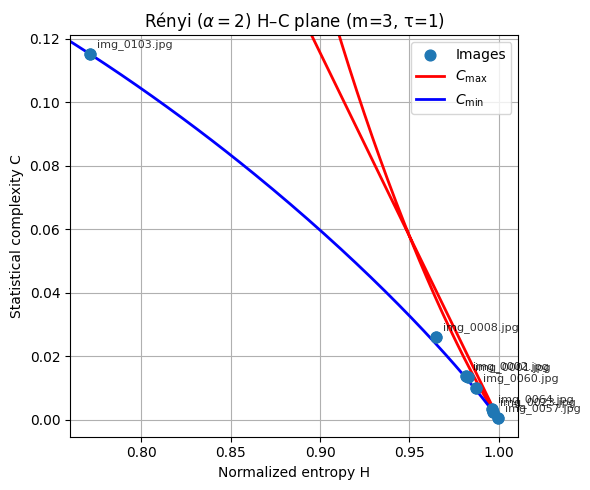

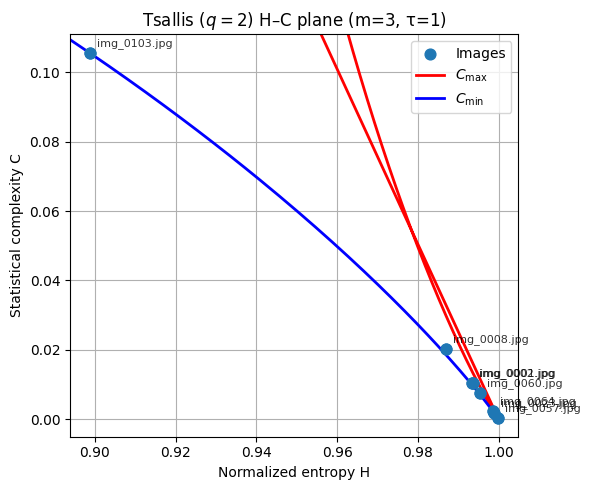

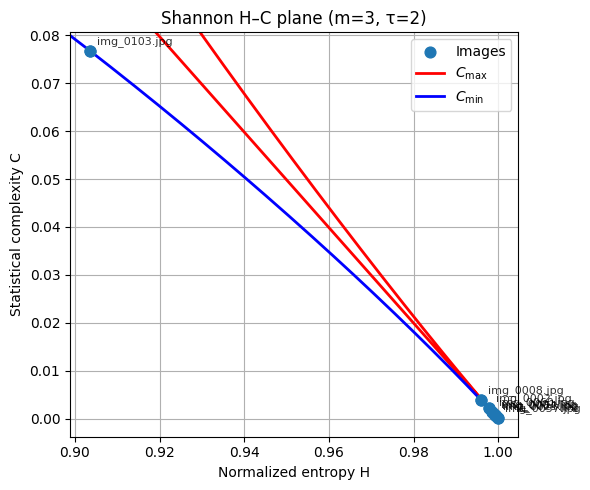

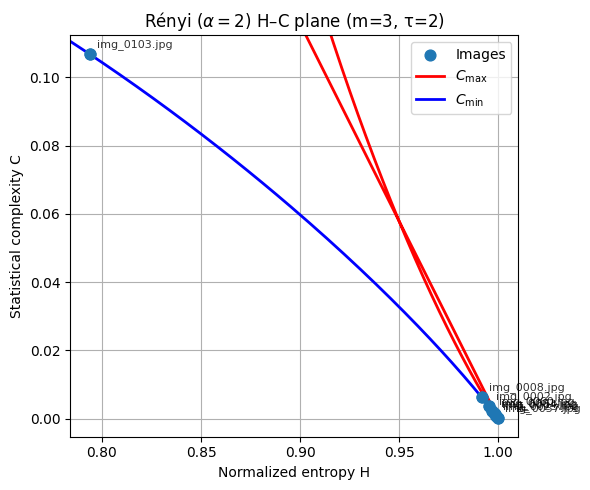

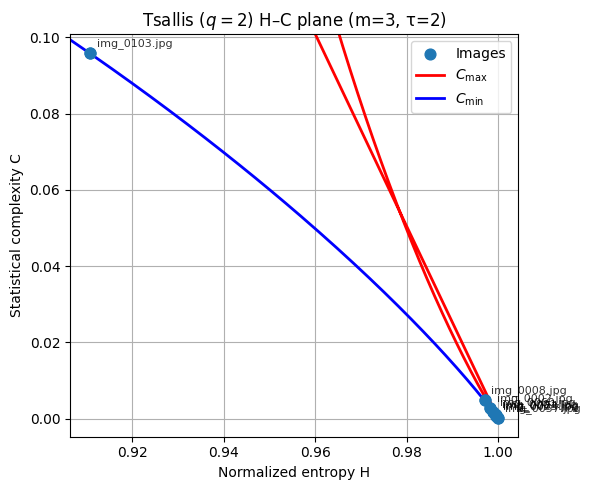

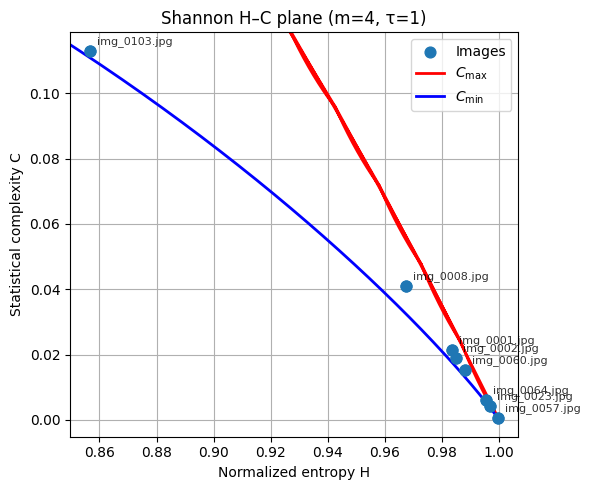

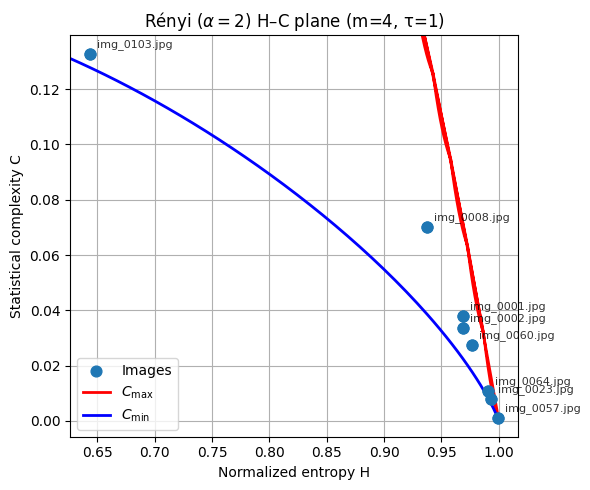

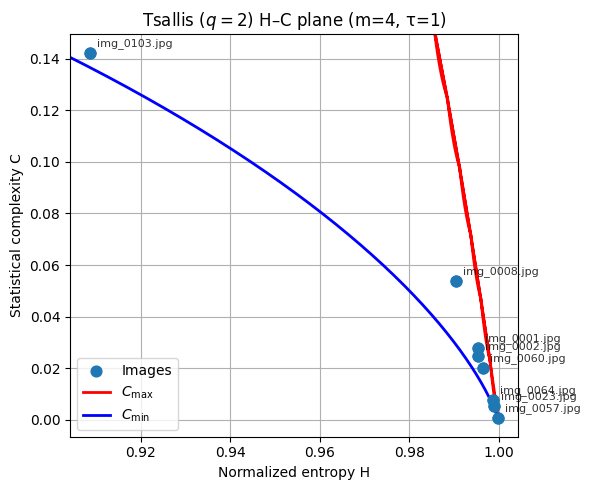

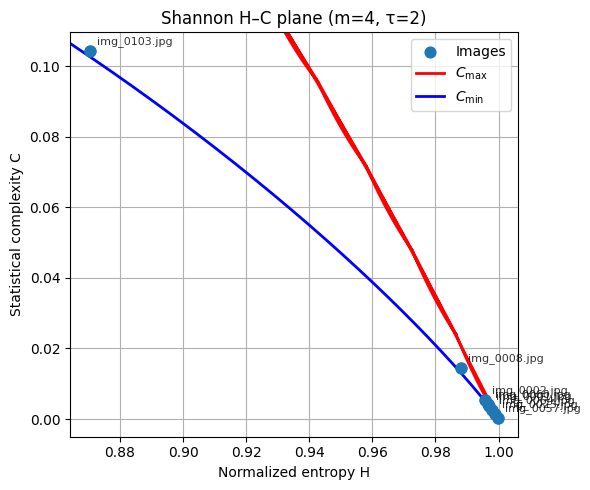

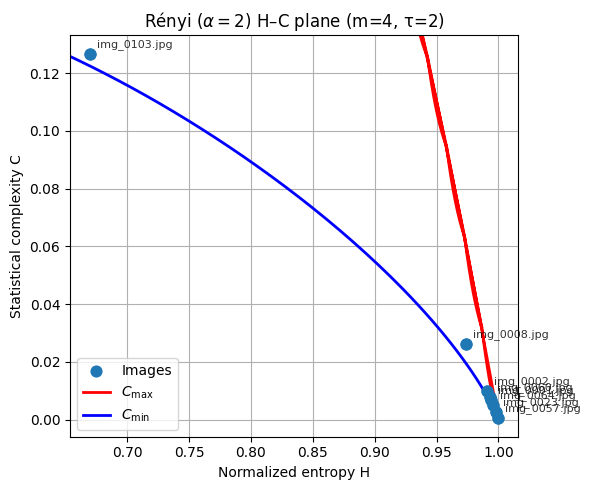

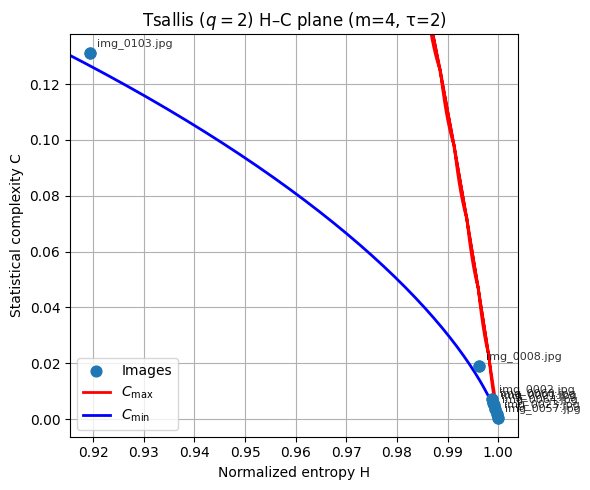

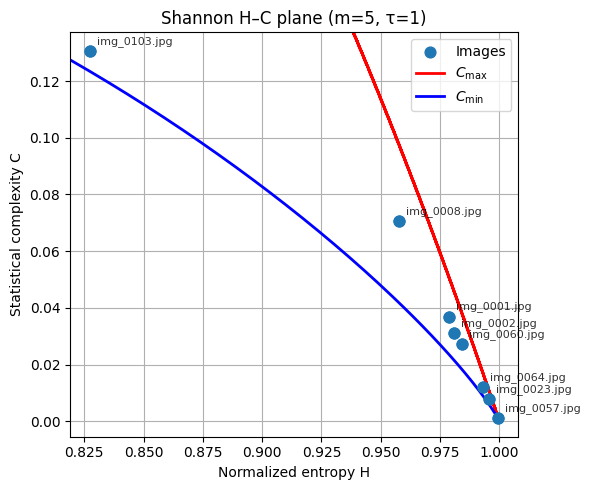

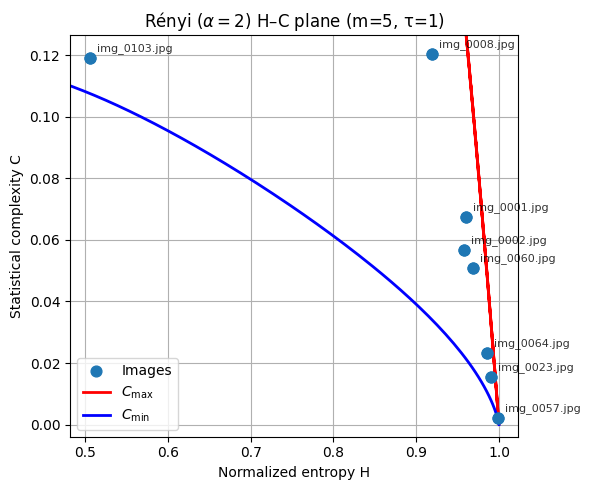

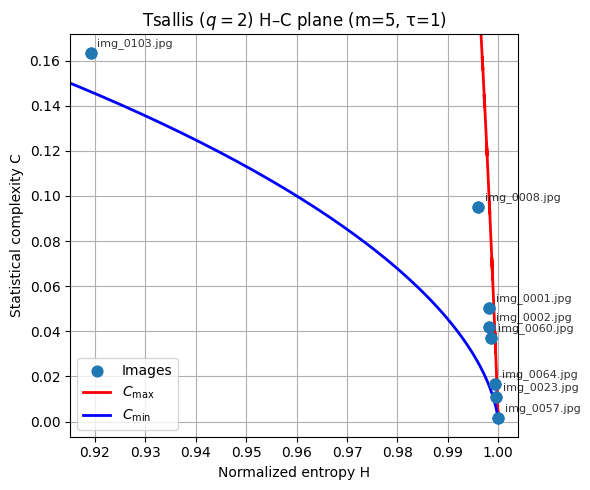

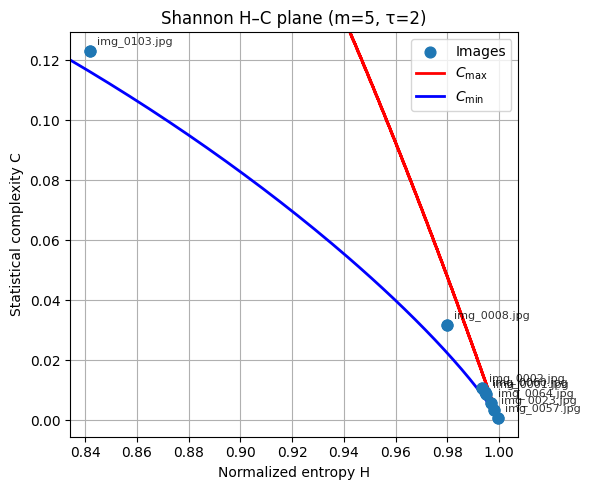

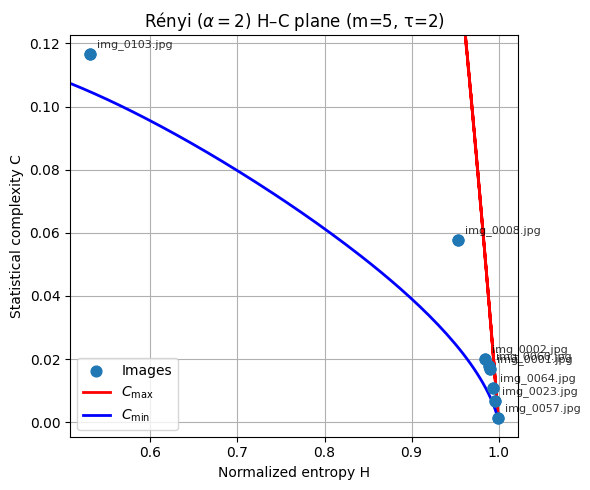

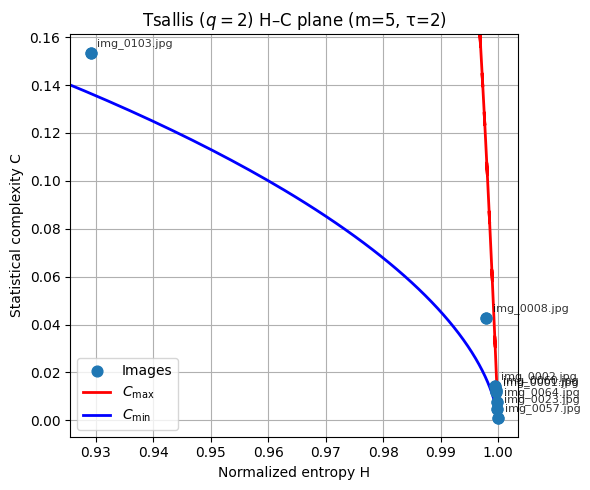

In [24]:
from itertools import product
importlib.reload(utils)
import math
for m, tau in product(m_values, tau_values):
    subset = entropy_complexity_df[
        (entropy_complexity_df.m == m) &
        (entropy_complexity_df.tau == tau)
    ]

    for spec in ENTROPY_SPECS.values():
        k = math.factorial(m)
        Hmin, Cmin = utils.Cmin_curve(k, spec['H_func'], spec['D_func'])
        Hmax, Cmax = utils.Cmax_curve(k, spec['H_func'], spec['D_func'])
        bounds = {
        "Hmin": Hmin,
        "Cmin": Cmin,
        "Hmax": Hmax,
        "Cmax": Cmax,
        }

        utils.plot_entropy_complexity_planes(
            subset_df=subset,
            m=m,
            tau=tau,
            spec=spec,
            bounds=bounds,
            labels=labels
        )
